# Classification des séries temporelles avec des filtres fonctionnelles

### Modules importés

In [92]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import imageio
from os import listdir
from os.path import isfile, join
import math
from scipy.interpolate import interp1d

## 1. Data Set

Le data set avec lequel on va travailler contient des enregistrements des positions des différentes parties de souris dans un rotator. Pour une souris, on a donc 8 parties (le nez, l'oreille gauche, droite, le centre du corps, les pattes arrière etc...).

Le problème avec ces données, c'est qu'ils sont beaucoup bruitées. Une grande partie des données sont soit manquantes soit abérantes. On va donc devoir selectionner les données les plus interessantes pour faire cette tâche de classification. Nous avons choisis de travailler en premier temps avec une partie du corps qui est le centre du corps de la souris, car c'est la partie qui est la plus souvent existantes et elle est corréler aux autre partie du corps.

### 1.1 Importer les données

Dans cette partie nous allons essayer d'extraire toute les données liées à la partie centrale de la souris. La méthode ci-dessous va créer deux dataframe un pour l'axe des x, puis un autre pour l'axe des y.

In [3]:
def build_DataFrame(path):
    
    with open(path) as f:
        lines = f.readlines()
    mice_dict = {}
    table = []
    times = []
    for l in lines[3:]:
        values = l.strip().split(',')
        time = eval(values.pop(0))
        times.append(time)
        values = [eval(v) if v!='' else -1 for v in values]
        table.append(values)
    table = np.array(table)
    for i, (mouse, body) in enumerate(zip(lines[0].strip().split(',')[1:], lines[1].strip().split(',')[1:])):
        if i%3==0:
            val = 'likelyhood'  
        elif i%3==1:
            val = 'x' 
        else:
            
            val = 'y'
            
        mice_dict[mouse, body, val] = table[:, i]
        
    return np.array(times), pd.DataFrame(mice_dict)

#### Data body center extraction

In [67]:
files = [f for f in listdir('../data')]

body_center_x = []
body_center_y = []
body_center_liklyhood = []

mouses = ["mus1", "mus2","mus3","mus4"]

for file in files:
    
    df = build_DataFrame("../data/"+file)[1]
    
    for mouse in mouses:
        
        body_center_x.append(np.array(df[mouse]["bodycentre"]["x"]))
        body_center_y.append(np.array(df[mouse]["bodycentre"]["y"]))
        body_center_liklyhood.append(np.array(df[mouse]["bodycentre"]["likelyhood"]))

Certaines données obtenues peuvent être aberrantes, nous allons donc regarder la vraisemblance de ces valeurs pour remplacer les valeurs fausse par l'objet nul.

In [76]:
def keep_likely_data(data_index):
    
    for i in range(len(body_center_x[data_index])):
        
        if(body_center_liklyhood[data_index][i] < 0.5):
            
            body_center_x[data_index][i] = math.nan
            body_center_y[data_index][i] = math.nan

Voici un aperçu de ce qu'on pourait avoir comme résultat

In [78]:
print("likelyhood",body_center_liklyhood[0][700:725])
print("x",body_center_x[0][700:725])
print("y",body_center_y[0][700:725])
keep_likely_data(0)
print("x",body_center_x[0][700:725])
print("y",body_center_y[0][700:725])

likelyhood [ 1.  1.  1.  1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.]
x [55.528 52.897 52.897 53.367 53.367    nan    nan    nan 51.387 51.593
 52.266 52.673 53.611 53.68  53.949 53.964 53.964    nan]
y [ 94.13   95.032  95.293  95.412  96.323     nan     nan     nan 102.104
 102.641 103.229 103.229 103.074 103.074 102.811 102.811 102.811     nan]
x [55.528 52.897 52.897 53.367 53.367    nan    nan    nan 51.387 51.593
 52.266 52.673 53.611 53.68  53.949 53.964 53.964    nan]
y [ 94.13   95.032  95.293  95.412  96.323     nan     nan     nan 102.104
 102.641 103.229 103.229 103.074 103.074 102.811 102.811 102.811     nan]


On a besoin maintenant de faire cette manipulation sur toutes les séries dans le data set

In [80]:
for i in range(len(body_center_x)):
    
    keep_likely_data(i)

### Visualisation de quelques données

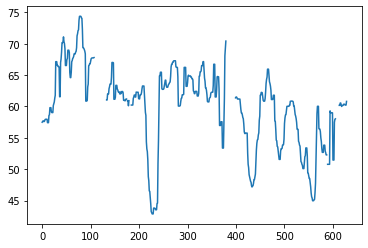

In [81]:
observation_x = body_center_x[20]

plt.plot(range(len(observation_x)), observation_x)

Cette série temporelle contient des valeurs interessantes entre 0 et 700 mais tous le reste n'est pas interessant, il faut donc se débarasser de toute la partie constante. De même pour l'axe des y.

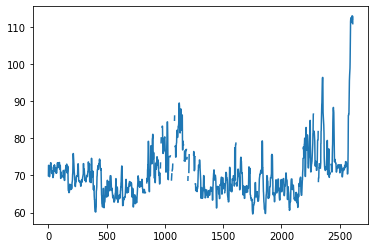

In [82]:
observation_y = body_center_y[90]

plt.plot(range(len(observation_y)), observation_y)

Il nous faut donc une méthode qui permet de retirer les parties inintéréssantes du data. Une façon de faire c'est de commencer à la fin est retiré des valeur petit à petit jusqu'à croiser une valeur strictement positive.

In [83]:
def extract(data):
    
    if(data[-1] > 0):
        
        return data
    
    else:
        
        index_to_delete = [len(data)-1]
        
        i = len(data)-2
        
        while((data[i] <= 0 or data[i] == math.nan) and i != 0):
            
            index_to_delete.append(i)
            
            i -= 1
            
        return np.delete(data, index_to_delete)

Voici ce qu'on obtient après la supression des données inutiles.

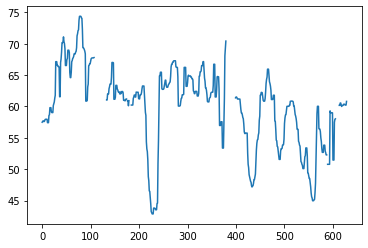

In [95]:
observation_x = body_center_x[20]

extracted_observation = extract(observation_x)

plt.plot(range(len(extracted_observation)), extracted_observation)

Il faut donc faire subire cette transformation à toutes les observations afin d'avoir que les informations utiles.

In [96]:
clean_data_X = []
clean_data_Y = []
for i in range(len(body_center_x)):
    
    clean_data_X.append(extract(body_center_x[i]))
    
    clean_data_Y.append(extract(body_center_y[i]))

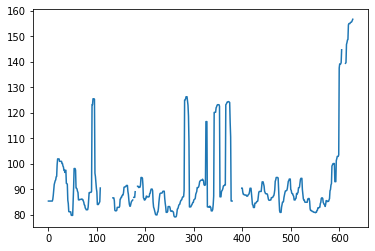

In [97]:
o = clean_data_Y[20]
plt.plot(range(len(o)), o)

### Interpolation

Une fois les données sont générées, il faut commencer à penser comment on peut remplire les vides dans nos séries temporelles? Cette une question qui est très important car une mauvaise manipulation peut produire de très mauvaise performances.

Pour commencer on va supprimer les séries dans le nombre de nan dépasse les 25% du data set. Pour cela nous proposons la méthode suivante.

In [147]:
def is_intresting(time_serie):
    
    number_of_nan = 0
    
    for i in range(len(time_serie)):
        
        
        if(np.isnan(time_serie[i])):
            
            number_of_nan += 1
            
    if(number_of_nan/len(time_serie) >= 0.25):
        
        return 0
    
    else:
        
        return 1

On crée un tableau qui va nous indiquer les données interessants

In [148]:
intresting_x_indicator = [is_intresting(body_center_x[i]) for i in range(len(body_center_x))]
intresting_y_indicator = [is_intresting(body_center_y[i]) for i in range(len(body_center_y))]

On peut commencer maintenant à chercher des méthodes pour interpoler nos séries temporelles.

In [149]:
def fill_nans_scipy1(padata, pkind='linear'): 

    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata)) 
    f = interp1d(agood_indexes , 
                 padata[agood_indexes] , 
                 bounds_error=False , 
                 copy=False , fill_value="extrapolate" , kind=pkind) 
    
    return f(aindexes)

On peut observer l'effet de l'interpolation dans la figure ci-dessous:

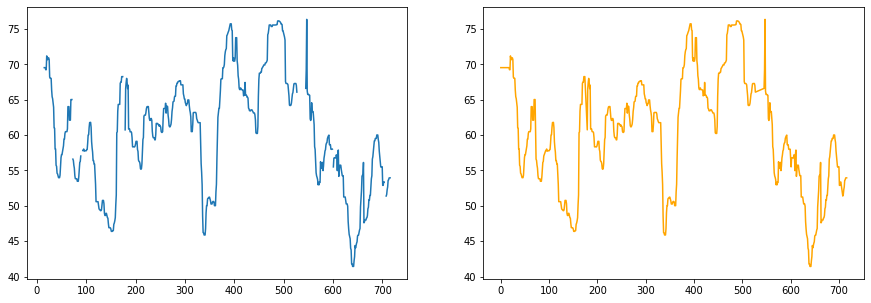

In [151]:
filled_serie = fill_nans_scipy1(clean_data_X[0])

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(range(len(clean_data_X[0])), clean_data_X[0])
ax[1].plot(range(len(filled_serie)), filled_serie, c = "orange")

On remarque que l'interpolation linéaire fait un très bon travail quand les données ne sont pas très manquant, ce qu'on va faire ensuite consiste à prendre les séries interessantes et de les interpoler pour passer à l'étape d'extraction.

In [157]:
X_Series = []
Y_Series = []

for i in range(len(intresting_x_indicator)):
    
    if(intresting_x_indicator[i] == 1 and intresting_y_indicator[i] == 1):
            
        X_Series.append(fill_nans_scipy1(clean_data_X[i]))
        Y_Series.append(fill_nans_scipy1(clean_data_Y[i]))

## 2.Extraction des features en utilisant des produits de convolution

Le but dans cette partie est d'utiliser plusieurs fonctions qui serviront comme filtre afin de différencier les séries temporelles. On va devoir utiliser plusieurs fonctions qui ont des comportement différents selon l'instant. Pour une série "s", nous cherchons à produire un vecteur (conv(f1,s), conv(f2,s), ..., conv(fn, s)), où: 
f1, f2,..., fn sont les fonctions de références et conv est la convolution de ces fonctions avec nos séries.

Nous proposons les fonctions suivantes:

<br>f1 = epsilon .sin(t.pi/ frequency)<br>
<br>f2 = alpha.log(t+1)<br>
<br>f3 = sigmoïd(t)<br>
<br>f4 = cte<br>
<br>f5 = 1/(t+1).sin(phi.t)<br>
<br>f6 = (t+1).sin(phi.t)<br>
<br>f7 = Arctan(t)<br>

Pour calculer la convolution de deux fonctions, il faut commencer par calculer les valeurs que notre fonction de référence peut prendre sur un interval.

In [289]:
def f1(time_serie, epsilon = 0.1, f = 4):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append(epsilon*math.sin(i*math.pi/f))
        
    return np.sum(np.convolve(result, time_serie))/len(time_serie)

Par exemple pour la première time serie on a la valeur

In [290]:
f1(X_Series[0])

14.639326886944527

In [288]:
def f2(time_serie, alpha = 0.05):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append(alpha*math.log(i+1)/(i+1)**2)
        
    return np.sum(np.convolve(result, time_serie))/len(time_serie)

In [291]:
f2(X_Series[0])

2.810543620096023

In [287]:
def f3(time_serie, alpha = 5*10**(-5),l = 1):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append(alpha/(1+math.exp(l*(-i))))
        
    return np.sum(np.convolve(result, time_serie))/len(time_serie)

In [292]:
f3(X_Series[0])

2.1709518239049683

In [286]:
def f4(time_serie, cte = 1):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append(cte)
        
    return cte*10**(-5)*np.sum(np.convolve(result, time_serie))/len(time_serie)

In [293]:
f4(X_Series[0])

0.4347750150000001

In [294]:
def f5(time_serie, alpha = 100, phi = 1):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append((alpha**2)*math.sin(i*math.pi*phi)/math.log(i+2))
        
    return 10**(7)*np.sum(np.convolve(result, time_serie))/len(time_serie)

In [256]:
f5_feature(X_Series[0])

-0.9669384473076325

In [285]:
def f6(time_serie,alpha = 100, phi = 1):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append(alpha*math.sin(i*math.pi*phi)*i)
        
    return 10**(5)*np.sum(np.convolve(result, time_serie))/len(time_serie)

In [295]:
f6(X_Series[0])

-0.3718514360548914

In [284]:
def f7(time_serie):
    
    result = []
    
    for i in range(len(time_serie)):
        
        result.append(math.atan(i)/math.pi)
        
    return 10**(-5)*np.sum(np.convolve(result, time_serie))/len(time_serie)

In [296]:
f7(X_Series[0])

0.21575712859193263

On va générer maitenant les traits de chaque série temporelle.

In [304]:
X = [[f1(x), f2(x), f3(x), f4(x), f5(x), f6(x), f7(x)] for x in X_Series]

## Clustering des données

Dans cette partie nous allons utiliser les traits générées pour voir les clusters que nous pouvons avoir dans les données que nous manipulons.

In [306]:
from sklearn.cluster import KMeans

In [307]:
model = KMeans(n_clusters=2)
model.fit(X)

KMeans(n_clusters=2)

In [308]:
print("center 1:", model.cluster_centers_[0])
print("center 2:", model.cluster_centers_[1])

center 1: [36.41997205  8.4924175  19.76835586  3.95542634 -4.47839188 -3.5125591
  1.97221835]
center 2: [ 7.0892351   6.92745028 17.83177789  3.56778681 -3.81715216 -3.12574896
  1.77936471]


In [314]:
X = np.array(X)
print(X.shape)

(122, 7)


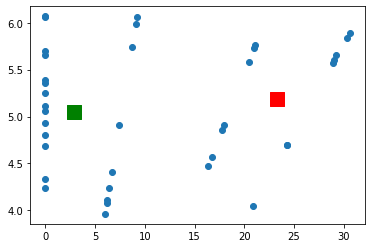

In [373]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(model.cluster_centers_[0][0], model.cluster_centers_[0][1], s=200, c='g', marker='s')
plt.scatter(model.cluster_centers_[1][0], model.cluster_centers_[1][1], s=200, c='r', marker='s')

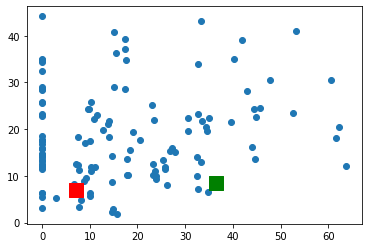

In [324]:
plt.scatter(X[:, 0], X[:, 2])
plt.scatter(model.cluster_centers_[0][0], model.cluster_centers_[0][1], s=200, c='g', marker='s')
plt.scatter(model.cluster_centers_[1][0], model.cluster_centers_[1][1], s=200, c='r', marker='s')

# Protocole sur les pattes arrières

In [332]:
files = [f for f in listdir('../data')]

left_limb_x = []
left_limb_y = []
left_limb_liklyhood = []

mouses = ["mus1", "mus2","mus3","mus4"]

for file in files:
    
    df = build_DataFrame("../data/"+file)[1]
    
    for mouse in mouses:
        
        left_limb_x.append(np.array(df[mouse]["lefthindlimb"]["x"]))
        left_limb_y.append(np.array(df[mouse]["lefthindlimb"]["y"]))
        left_limb_liklyhood.append(np.array(df[mouse]["lefthindlimb"]["likelyhood"]))

In [333]:
print(len(left_limb_x))

388


In [334]:
def keep_likely_data1(data_index):
    
    for i in range(len(left_limb_x[data_index])):
        
        if(left_limb_liklyhood[data_index][i] < 0.5):
            
            left_limb_x[data_index][i] = math.nan
            left_limb_y[data_index][i] = math.nan

In [335]:
for i in range(len(left_limb_x)):
    
    keep_likely_data1(i)

In [339]:
clean_data_X1 = []
clean_data_Y1 = []

for i in range(len(left_limb_x)):
    
    clean_data_X1.append(extract(left_limb_x[i]))
    clean_data_Y1.append(extract(left_limb_y[i]))

In [342]:
intresting_x_indicator = [is_intresting(clean_data_X1[i]) for i in range(len(clean_data_X1))]
intresting_y_indicator = [is_intresting(clean_data_Y1[i]) for i in range(len(clean_data_Y1))]

In [348]:
X1_Series = []
Y1_Series = []

for i in range(len(intresting_x_indicator)):
    
    if(intresting_x_indicator[i] == 1 or intresting_y_indicator[i] == 1):
            
        X1_Series.append(fill_nans_scipy1(clean_data_X1[i]))
        Y1_Series.append(fill_nans_scipy1(clean_data_Y1[i]))

In [350]:
X = [[f1(x), f2(x), f3(x), f4(x), f5(x), f6(x), f7(x)] for x in X1_Series]

In [364]:
len(X)

38

In [351]:
model = KMeans(n_clusters=2)
model.fit(X)

KMeans(n_clusters=2)

In [359]:
model.cluster_centers_

array([[ 2.86634305,  5.04979236, 11.76250907,  2.35354545, -2.65943693,
        -2.03390445,  1.17350221],
       [23.24828952,  5.19116445, 11.10477691,  2.2220286 , -2.65061163,
        -2.13314662,  1.10768184]])

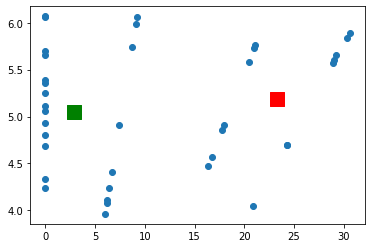

In [362]:
X = np.array(X)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(model.cluster_centers_[0][0], model.cluster_centers_[0][1], s=200, c='g', marker='s')
plt.scatter(model.cluster_centers_[1][0], model.cluster_centers_[1][1], s=200, c='r', marker='s')

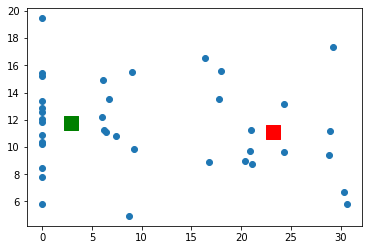

In [363]:
X = np.array(X)
plt.scatter(X[:, 0], X[:, 2])
plt.scatter(model.cluster_centers_[0][0], model.cluster_centers_[0][2], s=200, c='g', marker='s')
plt.scatter(model.cluster_centers_[1][0], model.cluster_centers_[1][2], s=200, c='r', marker='s')

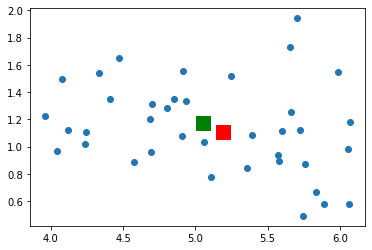

In [372]:
X = np.array(X)
plt.scatter(X[:, 1], X[:, 6])
plt.scatter(model.cluster_centers_[0][1], model.cluster_centers_[0][6], s=200, c='g', marker='s')
plt.scatter(model.cluster_centers_[1][1], model.cluster_centers_[1][6], s=200, c='r', marker='s')